In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [21]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NeuralNetwork(nn.Module):
    def __init__(self, h=10, input_dim=1, output_dim=1, use_bias=True):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.Tanh()
#         self.activation = nn.ReLU()
        self.h = h
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, h, bias=use_bias),
            self.activation,
            nn.Linear(h, output_dim, bias=use_bias)
        )
        
    def init_network_param(self):
        for param in self.parameters():
            if np.random.rand() > 0.5:
                nn.init.uniform_(param, -3, 3)
            else:
                nn.init.normal_(param, std=3)
        return 

    def forward(self, x):
        return self.linear_relu_stack(x)

    
class LearningMachine(object):
    def __init__(self, n, true_func, model, optim, sigma=0.2, batch_size=64, loss_fn=nn.MSELoss()):
        self.n = n
        self.true_func = true_func
        self.model = model
        self.optim = optim
        self.sigma = sigma
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        
        self.X_train = torch.rand(n).reshape(-1, 1)
        self.y_train = true_func(self.X_train) + torch.randn_like(self.X_train) * sigma
        self.dataset = MyDataset(self.X_train, self.y_train)
        self.train_dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
    
    def train_with_budget(self, gd_budget=10000):
        count = 0
        while count < gd_budget:
            size = len(self.train_dataloader.dataset)
            total_num_batches = len(self.train_dataloader)
            for batch, (X, y) in enumerate(self.train_dataloader):
                # Compute prediction and loss
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                count += 1
                
                if count > gd_budget:
                    break
        return 
    
    def train_one_epoch(self):
        self.train(1)
        return 
    
    def train(self, num_epoch, verbose=False):
        for t in range(num_epoch):
            self.train_loop(verbose=verbose)
        return 
    
    def train_loop(self, report_rate=4, verbose=False):
        size = len(self.train_dataloader.dataset)
        total_num_batches = len(self.train_dataloader)
        for batch, (X, y) in enumerate(self.train_dataloader):
            # Compute prediction and loss
            pred = self.model(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

            if verbose: 
                if batch % max(1, (total_num_batches // (report_rate))) == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return 
                    
    def plot(self, ax=None, figsize=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        x = torch.linspace(0, 1, steps=50).reshape(-1, 1)
        y = self.true_func(x)
        ax.plot(x, y, "b--", alpha=0.5)
        ax.scatter(self.X_train, self.y_train, s=5, alpha=0.5)

        ax.plot(x, self.model(x.reshape(-1, 1)).detach(), "r--")
        return ax
    
    def estimated_functional_mse(self, num_divisions=100):
        x = torch.linspace(0, 1, steps=num_divisions).reshape(-1, 1)
        y_true = self.true_func(x[:-1])
        y_pred = self.model(x[:-1]).detach()
        return torch.sum((y_true - y_pred)**2 * torch.diff(x, dim=0))



n=   20, K=0.6799
n=   20, K=0.5510
n=   20, K=0.4567
n=   20, K=0.3964
n=   20, K=0.2676
n=   20, K=0.3785
n=   20, K=1.7560
n=   20, K=0.2683
n=   20, K=0.9497
CPU times: user 1min 10s, sys: 294 ms, total: 1min 10s
Wall time: 1min 10s


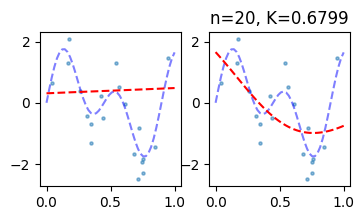

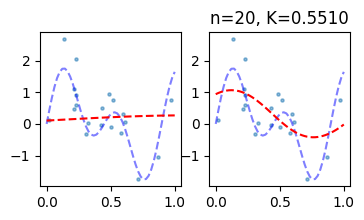

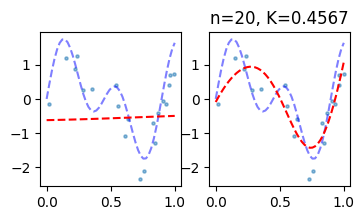

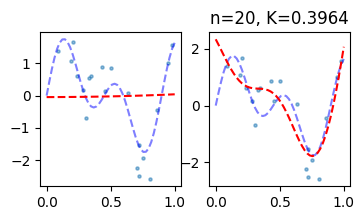

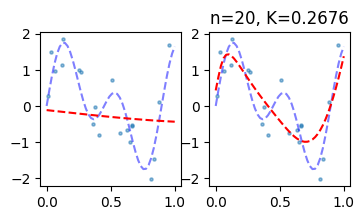

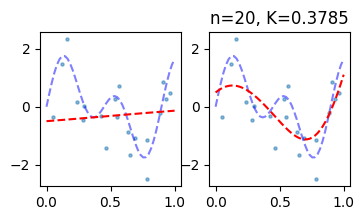

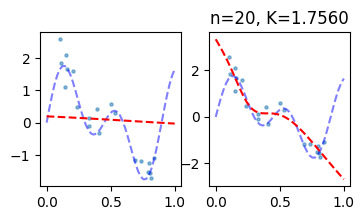

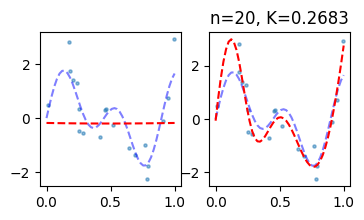

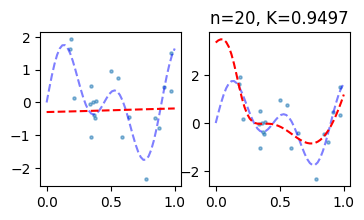

In [65]:
%%time 

def true_func(x):
#     return true_network(x).detach()
    return torch.sin(7 * x) + torch.sin(49 * x) #+ torch.sin(49 * x)
#     return x
#     return torch.zeros_like(x)

sigma = 0.5
loss_fn = nn.MSELoss()
num_epoch = 200


rec = []
s = 2000
n = 20
xx = range(10000, 100000, 10000)
for budget in xx:
#     batch_size = 64 if n > (64 * 5) else max(n // 5, 1)
#     batch_size = max(n // 100, 1)
    batch_size = 10
    model = NeuralNetwork(h=100, use_bias=True)
    optim = torch.optim.Adam(model.parameters(), lr=0.001)

    machine = LearningMachine(n, true_func, model, optim, sigma=sigma, batch_size=batch_size, loss_fn=loss_fn)
    fig, ax = plt.subplots(1, 2, figsize=(4, 2))
    machine.plot(ax=ax[0])
    
#     machine.train(num_epoch)
    machine.train_with_budget(gd_budget=budget)
#     machine.train_one_epoch()
    machine.plot(ax=ax[1])
    
    k_est = machine.estimated_functional_mse()
    
    ax[1].set_title(f"n={n}, K={k_est:.4f}")
    rec.append((n, k_est))
    print(f"n={n:>5d}, K={k_est:.4f}")

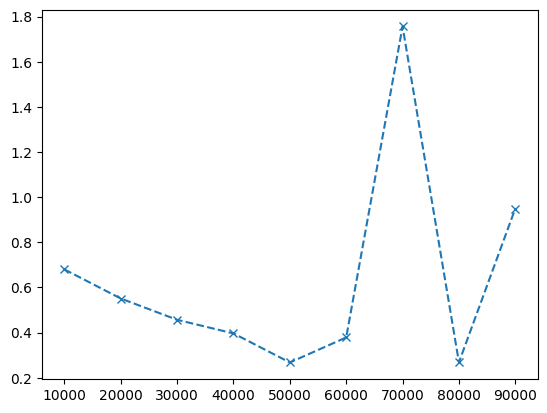

In [66]:
dat = np.array(rec)

plt.plot(xx, dat[:, 1], "x--")

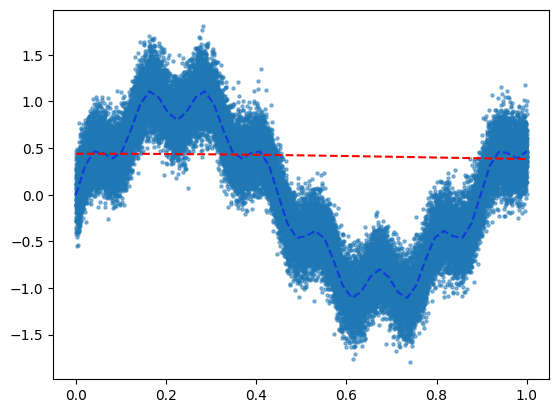

In [70]:
def true_func(x):
    return torch.sin(7 * x) + 0.2 * torch.sin(49 * x)# + torch.sin(28 * x)
#     return x
#     return torch.zeros_like(x)

n = 40000
sigma = 0.2
X_train = torch.rand(n).reshape(-1, 1)
y_train = true_func(X_train) + torch.randn_like(X_train) * sigma

dataset = MyDataset(X_train, y_train)
# batch_size = len(dataset) // 2
batch_size = n // 100
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NeuralNetwork(h=150)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


x = torch.linspace(0, 1, steps=50)
y = true_func(x)
plt.plot(x, y, "b--", alpha=0.5)
plt.scatter(X_train, y_train, s=5, alpha=0.5)

plt.plot(x, model(x.reshape(-1, 1)).detach(), "r--")

In [78]:
def train_loop(dataloader, model, loss_fn, optimizer, report_rate=4, verbose=True):
    size = len(dataloader.dataset)
    total_num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose: 
            if batch % max(1, (total_num_batches // (report_rate))) == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

num_epoch = 5000
for t in range(num_epoch):
    if t % (num_epoch // 4) == 0:
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optim, verbose=True)
    else:
        train_loop(train_dataloader, model, loss_fn, optim, verbose=False)

print("Done!")


Epoch 1
-------------------------------
loss: 0.058451  [    0/40000]
loss: 0.054789  [10000/40000]
loss: 0.065726  [20000/40000]
loss: 0.061438  [30000/40000]

Epoch 1251
-------------------------------
loss: 0.052890  [    0/40000]
loss: 0.054047  [10000/40000]
loss: 0.070356  [20000/40000]
loss: 0.057196  [30000/40000]

Epoch 2501
-------------------------------
loss: 0.050959  [    0/40000]
loss: 0.058573  [10000/40000]
loss: 0.056863  [20000/40000]
loss: 0.062106  [30000/40000]

Epoch 3751
-------------------------------
loss: 0.067311  [    0/40000]
loss: 0.062382  [10000/40000]
loss: 0.062408  [20000/40000]
loss: 0.058126  [30000/40000]
Done!


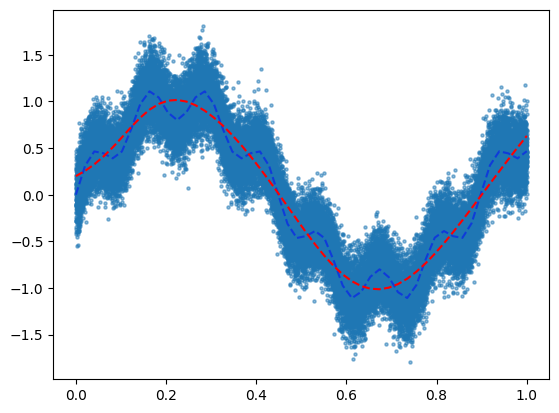

In [77]:
x = torch.linspace(0, 1, steps=50)
y = true_func(x)
plt.plot(x, y, "b--", alpha=0.5)
# plt.plot(x, torch.sin(7 * x), "g--", alpha=0.5)
plt.scatter(X_train, y_train, s=5, alpha=0.5)

plt.plot(x, model(x.reshape(-1, 1)).detach(), "r--")

In [ ]:
df_re